In [90]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [91]:
DRIVER_NAME = 'SQL Server'
SERVER_NAME = 'LAPTOP-3R59J9VQ'  # Replace with your server name
DATABASE_NAME = 'CompanyX'       # Replace with your database name

# Connection string for SQLAlchemy
conn_str = f"mssql+pyodbc://{SERVER_NAME}/{DATABASE_NAME}?driver=SQL+Server+Native+Client+11.0"

# Create SQLAlchemy engine
engine = create_engine(conn_str)

In [92]:
query = """
SELECT 
    p.Productname,
    p.ProductID,
    p.Category,
    f.Revenue,
    f.ROI,
    f.NetProfitMargin
FROM 
    Fact f
JOIN 
    DimProduct p ON f.ProductID = p.ProductID
"""

# Load data into a pandas DataFrame
data = pd.read_sql(query, engine)
print("Data loaded successfully.")

# Preview the data
print("Data Sample:")
print(data.head())

Data loaded successfully.
Data Sample:
               Productname  ProductID     Category  Revenue       ROI  \
0      Patch Kit/8 Patches        873  Accessories    1.374  0.335668   
1    Touring-3000 Blue, 58        959        Bikes  445.410 -0.041866   
2    Touring-3000 Blue, 58        959        Bikes  445.410 -0.028718   
3  Touring-3000 Yellow, 44        961        Bikes  445.410 -0.039488   
4  Touring-3000 Yellow, 44        961        Bikes  445.410 -0.043436   

   NetProfitMargin  
0        37.663755  
1        -3.600009  
2        -3.600009  
3        -3.600009  
4        -3.600009  


In [93]:
data = data.dropna()

In [94]:
# Check for NaN values in the dataset
print(data.isnull().sum())

Productname        0
ProductID          0
Category           0
Revenue            0
ROI                0
NetProfitMargin    0
dtype: int64


In [95]:
# Define function to preprocess data for each category
def preprocess_category(data, category_name):
    # Filter data for the given category
    category_data = data[data['Category'] == category_name]
    
    # Select relevant features for clustering
    features = category_data[['Revenue', 'ROI']]
    
    # Standardize the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    return category_data, features_scaled

# Example: Preprocess the 'Bike' category
bikes_data, bikes_features = preprocess_category(data, 'Bikes')
clothing_data, clothing_features = preprocess_category(data, 'Clothing')
components_data, components_features = preprocess_category(data, 'Components')
accessories_data, accessories_features = preprocess_category(data, 'Accessories')
print("Bike data: ")
print(bikes_data.describe())
print("Clothings data: ")
print(clothing_data.describe())
print("Components data: ")
print(components_data.describe())
print("Accessories data: ")
print(accessories_data.describe())

Bike data: 
         ProductID       Revenue          ROI  NetProfitMargin
count  1892.000000   1892.000000  1892.000000      1892.000000
mean    861.419662   2614.546917    -0.064909        -4.844985
std      97.957439   2693.477702     0.495972        19.959925
min     749.000000    112.998000    -4.222552      -172.764031
25%     778.000000    874.794000    -0.203398        -6.066661
50%     795.500000   1466.010000    -0.070200        -3.599999
75%     969.000000   3361.470000     0.149032         6.266665
max     999.000000  20195.912000     2.587926         9.078667
Clothings data: 
        ProductID      Revenue         ROI  NetProfitMargin
count  390.000000   390.000000  390.000000       390.000000
mean   815.179487   167.953105    0.725558         8.308762
std     71.463285   168.019198    2.047930        32.538025
min    709.000000     5.186500   -9.595960       -45.600825
25%    715.000000    56.515600   -0.383297       -28.333333
50%    858.500000   115.361600    0.479584  

In [96]:

# Function to find the optimal epsilon value using k-distance graph
def find_optimal_eps(features_scaled, n):
    from sklearn.neighbors import NearestNeighbors
    neighbors = NearestNeighbors(n_neighbors = n)  # k is the number of nearest neighbors
    neighbors_fit = neighbors.fit(features_scaled)
    distances, indices = neighbors_fit.kneighbors(features_scaled)
    distances = np.sort(distances[:, 4], axis=0)  # Take the 5th nearest distance for each point

    # Plot k-distance graph
    plt.figure(figsize=(8, 6))
    plt.plot(distances)
    plt.title("K-Distance Graph for Finding Optimal Epsilon")
    plt.xlabel("Data Points Sorted by Distance")
    plt.ylabel("5th Nearest Distance")
    plt.show()


In [97]:
def find_optimal_min_samples(data, eps, min_samples_range):
    """
    Find the optimal min_samples for DBSCAN using silhouette score and noise ratio.
    
    Parameters:
    - data: ndarray, Scaled feature data.
    - eps: float, Fixed eps value for DBSCAN.
    - min_samples_range: list or range, Range of min_samples to evaluate.
    
    Returns:
    - dict: Best min_samples with corresponding silhouette score and noise ratio.
    """
    best_min_samples = None
    best_score = -1
    results = []

    print("Evaluating Min Samples...")
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(data)
        
        # Ignore clusters with all noise
        if len(set(labels)) <= 1:
            continue
        
        # Calculate the noise ratio (percentage of points classified as noise)
        noise_ratio = np.sum(labels == -1) / len(labels)

        # Calculate Silhouette Score (ignoring noise points)
        if len(set(labels)) > 1:
            silhouette_avg = silhouette_score(data[labels != -1], labels[labels != -1])
        else:
            silhouette_avg = -1
        
        results.append((min_samples, silhouette_avg, noise_ratio))
        
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_min_samples = min_samples

    print("Evaluation Results:")
    for min_samples, silhouette_avg, noise_ratio in results:
        print(f"min_samples: {min_samples}, Silhouette Score: {silhouette_avg:.4f}, Noise Ratio: {noise_ratio:.2f}")

    print(f"\nBest min_samples: {best_min_samples} with Silhouette Score: {best_score:.4f}")
    return {"min_samples": best_min_samples, "silhouette_score": best_score}

In [89]:
min_samples_range = range(3, 15)
find_optimal_min_samples(bikes_features, 1.0, min_samples_range)

Evaluating Min Samples...


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [65]:

# Function to perform clustering with DBSCAN and visualize results
def perform_dbscan_clustering(data, category_name, eps, min_samples):
    # Preprocess the data
    category_data, features_scaled = preprocess_category(data, category_name)

    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    category_data['Cluster'] = dbscan.fit_predict(features_scaled)

    # Identify noise points
    noise_points = category_data[category_data['Cluster'] == -1]
    print(f"Number of noise points in {category_name}: {len(noise_points)}")

    # Visualize clustering results
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=category_data, x='Revenue', y='ROI',
                    hue='Cluster', palette='tab10', s=100)

    plt.title(f'DBSCAN Clustering Results for {category_name} Category')
    plt.xlabel('Total Revenue')
    plt.ylabel('Return on Investment')
    plt.legend(title='Cluster', loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.show()

    # Analyze cluster statistics
    cluster_summary = category_data[category_data['Cluster'] != -1].groupby('Cluster')[
        ['Revenue', 'ROI', 'NetProfitMargin']].mean()
    print(f"Cluster Summary for {category_name} Category:")
    print(cluster_summary)

    return category_data


--- DBSCAN Clustering for Bikes Category ---


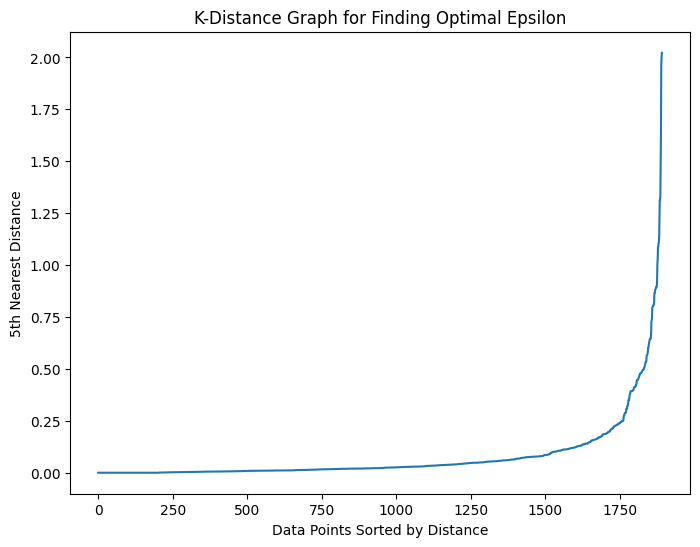

Number of noise points in Bikes: 154


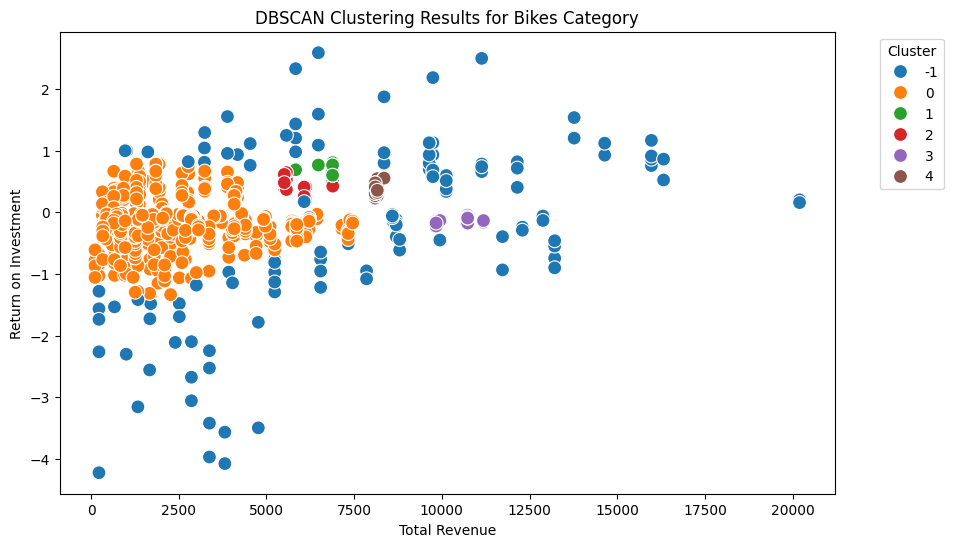

Cluster Summary for Bikes Category:
              Revenue       ROI  NetProfitMargin
Cluster                                         
0         1914.580455 -0.078554        -4.295694
1         6728.363012  0.673010         8.521966
2         5792.804676  0.454159         7.921561
3        10322.077390 -0.136923        -1.565775
4         8147.974667  0.369577         6.579110


In [70]:
# Example: Perform DBSCAN on the 'Bike' category
print(f"\n--- DBSCAN Clustering for Bikes Category ---")
find_optimal_eps(bikes_features, 15)  # Use k-distance graph to determine the best `eps`
bikes_dbscan_data = perform_dbscan_clustering(bikes_data, 'Bikes', eps=0.4, min_samples=15)

In [57]:
print(f"\n--- DBSCAN Clustering for Components Category ---")
find_optimal_eps(components_features, 10)
components_dbscan_data = perform_dbscan_clustering(components_data, 'Components', eps=0.5, min_samples=10)


--- DBSCAN Clustering for Components Category ---


TypeError: find_optimal_eps() takes 1 positional argument but 2 were given

In [ ]:

print(f"\n--- DBSCAN Clustering for Clothing Category ---")
find_optimal_eps(clothing_features)
clothing_dbscan_data = perform_dbscan_clustering(clothing_data, 'Clothing', eps=0.6, min_samples=4)

In [ ]:

print(f"\n--- DBSCAN Clustering for Accessories Category ---")
find_optimal_eps(accessories_features)
accessories_dbscan_data = perform_dbscan_clustering(accessories_data, 'Accessories', eps=0.4, min_samples=3)